# Analysis
### Visualizing Subjugation DC
#### Kwadwo Alfajiri Shah
#### 12 Nov 23
#### Updated: 27 Jan 24

Principal Component Analysis (PCA) and clustering analysis on DC Census block group-level characteristics.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from ppca import PPCA
from sklearn.cluster import KMeans, DBSCAN
from datetime import date

## multiple printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [12]:
warnings.simplefilter(action='ignore', category=RuntimeWarning)

### 1. Read data

In [13]:
dc = pd.read_csv("../data/dc_bg_characteristics_scaled_20240127.csv")
dc.shape
dc.head()
dc.describe()

(555, 13)

,GEOID,NAME,median_income,pct_service,pct_unemp,pct_not_labor,pct_black,pct_public_transit,pct_commute30,pct_poverty,long_centroid,lat_centroid,has_missing
0,110010001011,"Block Group 1, Census Tract 1.01, District of ...",0.731603,-0.514239,-0.589524,0.112327,-1.279042,-1.128366,-1.975999,-0.719556,-77.054725,38.908588,False
1,110010001021,"Block Group 1, Census Tract 1.02, District of ...",0.958231,-0.603732,-0.835314,-1.072545,-1.245247,-1.072531,-1.033557,-0.737394,-77.061333,38.914168,False
2,110010001022,"Block Group 2, Census Tract 1.02, District of ...",1.222093,-0.682336,-0.546640,0.443394,-1.234934,-1.308904,-0.118535,-0.886528,-77.060651,38.909108,False
3,110010001023,"Block Group 3, Census Tract 1.02, District of ...",0.355750,-0.591926,-0.508618,0.405215,-1.279042,-1.404548,-0.507124,-0.604184,-77.061240,38.899200,False
4,110010002012,"Block Group 2, Census Tract 2.01, District of ...",NaN,0.719690,-0.091418,2.277609,-1.015410,-1.640793,-1.985315,NaN,-77.072854,38.908728,True


,GEOID,median_income,pct_service,pct_unemp,pct_not_labor,pct_black,pct_public_transit,pct_commute30,pct_poverty,long_centroid,lat_centroid
count,5.550000e+02,4.970000e+02,5.520000e+02,5.550000e+02,5.550000e+02,5.550000e+02,5.530000e+02,5.530000e+02,5.500000e+02,555.000000,555.000000
mean,1.100101e+11,-2.001529e-16,-1.287215e-16,2.560514e-17,-1.792360e-16,2.048411e-16,1.349132e-16,-1.156399e-16,-5.684342e-16,-77.013655,38.909256
std,4.148615e+05,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.038757,0.034270
min,1.100100e+11,-1.752605e+00,-1.006962e+00,-8.353139e-01,-1.824849e+00,-1.279042e+00,-1.982381e+00,-2.892033e+00,-1.015144e+00,-77.109699,38.811449
25%,1.100100e+11,-7.758049e-01,-7.447350e-01,-6.783062e-01,-7.619011e-01,-9.669020e-01,-6.864290e-01,-6.908838e-01,-7.580655e-01,-77.037655,38.888047
50%,1.100101e+11,-1.008603e-01,-3.324852e-01,-3.153804e-01,-4.677675e-02,-2.012154e-01,-7.247227e-02,-3.299926e-02,-3.137851e-01,-77.016076,38.910388
75%,1.100101e+11,5.166731e-01,4.466102e-01,3.156714e-01,6.153482e-01,1.001685e+00,6.212409e-01,7.303306e-01,5.078124e-01,-76.988534,38.933164
max,1.100198e+11,2.294568e+00,6.283633e+00,5.419287e+00,4.658087e+00,1.549800e+00,3.956459e+00,2.488554e+00,4.091529e+00,-76.914445,38.986100


In [14]:
## drop non-numeric variables for clustering
dc2 = dc.drop(['GEOID', 'NAME', 'has_missing'], axis = 1)

## drop location for PCA
dc3 = dc2.drop(['long_centroid', 'lat_centroid'], axis = 1)

### 2. PCA

I use this [pca-magic](https://github.com/allentran/pca-magic/tree/master) implementation because it handles missing values. sklearn doesn't like the NaNs in my data.\
missingness isn't a huge problem, so i figure it's fine

In [15]:
## fit model
ppca = PPCA()
ppca.fit(dc3.to_numpy())

In [16]:
## factor loadings
# loadings_mtx = ppca.C
loadings_mtx = np.transpose(ppca.C)
loadings = pd.DataFrame(loadings_mtx, index=['median_income', 'pct_service', 'pct_unemp', 'pct_not_labor',
       'pct_black', 'pct_public_transit', 'pct_commute30', 'pct_poverty'],
                        columns=['Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8'])
loadings


,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8
median_income,0.388903,-0.391134,-0.361064,-0.300203,-0.467797,-0.166404,-0.234044,-0.417108
pct_service,-0.046924,0.079541,-0.076502,0.433585,0.008452,-0.626813,-0.599483,0.212785
pct_unemp,0.050776,-0.041990,0.618456,-0.435049,0.223664,-0.559522,0.106031,-0.222644
pct_not_labor,0.332340,-0.173528,-0.193386,0.525503,0.204337,-0.306456,0.612089,-0.188585
pct_black,-0.106185,0.707578,-0.478742,-0.239089,0.201083,-0.173806,0.047544,-0.358884
pct_public_transit,0.727658,0.518771,0.296436,0.086940,-0.264731,0.116783,-0.037703,0.144276
pct_commute30,-0.046286,0.016112,0.301291,0.391063,0.162008,0.312739,-0.330642,-0.721467
pct_poverty,0.436601,-0.196884,-0.189870,-0.196999,0.743338,0.175450,-0.294859,0.159625


array([0.41929173, 0.58728674, 0.68854371, 0.77937689, 0.86033893,
       0.92212743, 0.96967355, 1.00180505])

<Figure size 1000x500 with 0 Axes>

Text(0.5, 0, 'Components')

Text(0, 0.5, 'PVE')

(0.0, 1.0)

Text(0.5, 1.0, 'Cumulative PVE')

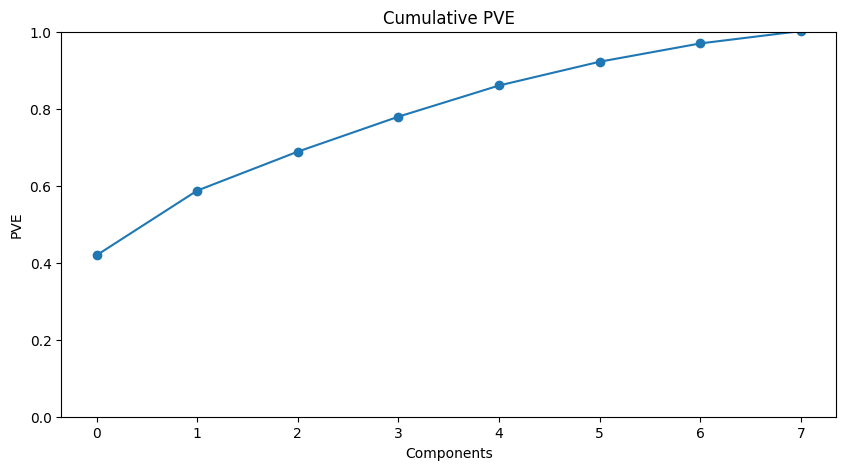

In [17]:
## ppca has cumulative PVE
ppca.var_exp

## plot PVE
plt.figure(figsize=(10,5))
plt.plot(ppca.var_exp,marker = 'o')
plt.xlabel("Components")
plt.ylabel("PVE")
plt.ylim(0,1)
# plt.xticks(np.arange(4),('PC1','PC2','PC3','PC4'))
plt.title("Cumulative PVE")
plt.show()

The factor loadings table shows that **the first component loads on poverty and public transportation** and perhaps income, and **the second component loads strongly on Black population** (and perhaps public transit). The elbow in the PVE chart below is at two components, so conducting analysis on these two components alone might be interesting.

### 3. Clustering

#### a. K-means (no PCA)

I use a kmeans implementation from [this stack overflow post](https://stackoverflow.com/questions/29420737/pca-with-missing-values-in-python). this method fills in missing values with cluster centroids. this surely introduces bias.

In [18]:
np.nanmean(dc3, 0, keepdims=1)

array([[-2.00152883e-16, -1.28721510e-16,  2.56051436e-17,
        -1.79236005e-16,  2.04841149e-16,  1.34913178e-16,
        -1.15639867e-16, -5.68434189e-16]])

In [19]:
## implementation from stack overflow
def kmeans_missing(X, n_clusters, max_iter=10):
    """Perform K-Means clustering on data with missing values.

    Args:
      X: An [n_samples, n_features] array of data to cluster.
      n_clusters: Number of clusters to form.
      max_iter: Maximum number of EM iterations to perform.

    Returns:
      labels: An [n_samples] vector of integer labels.
      centroids: An [n_clusters, n_features] array of cluster centroids.
      X_hat: Copy of X with the missing values filled in.
    """

    # Initialize missing values to their column means
    missing = ~np.isfinite(X)
    mu = np.nanmean(X, 0, keepdims=1)
    X_hat = np.where(missing, mu, X)

    for i in range(max_iter):
        if i > 0:
            # initialize KMeans with the previous set of centroids. this is much
            # faster and makes it easier to check convergence (since labels
            # won't be permuted on every iteration), but might be more prone to
            # getting stuck in local minima.
            cls = KMeans(n_clusters, init=prev_centroids)
        else:
            # km++ initialization
            cls = KMeans(n_clusters)

        # perform clustering on the filled-in data
        labels = cls.fit_predict(X_hat)
        centroids = cls.cluster_centers_
        sse = cls.inertia_

        # fill in the missing values based on their cluster centroids
        X_hat[missing] = centroids[labels][missing]

        # when the labels have stopped changing then we have converged
        if i > 0 and np.all(labels == prev_labels):
            break

        prev_labels = labels
        prev_centroids = cls.cluster_centers_
        
#     sse = cls.intertia_

    return labels, centroids, X_hat, sse

In [20]:
## compute SSE for k: [1,25]
sse = dict()

for k in range(1,26):
    km = kmeans_missing(dc2, n_clusters=k)
    
    name = 'k'+str(k)
    sse[name]=km[3]

sse

{'k1': 4363.48280601096,
 'k2': 3026.4191649784284,
 'k3': 2679.077169940749,
 'k4': 2421.9665805073896,
 'k5': 2247.999569551754,
 'k6': 2092.365629925242,
 'k7': 1970.4440331370397,
 'k8': 1875.2435201182004,
 'k9': 1791.9885983667307,
 'k10': 1727.8727425585864,
 'k11': 1676.274505146282,
 'k12': 1624.4564115965918,
 'k13': 1583.4283094525358,
 'k14': 1543.675711739298,
 'k15': 1487.8381654412865,
 'k16': 1447.899294129254,
 'k17': 1400.25130326121,
 'k18': 1364.7170569153766,
 'k19': 1339.4056978520548,
 'k20': 1322.2723277691616,
 'k21': 1299.2893216973494,
 'k22': 1256.3457776700077,
 'k23': 1226.5115843393241,
 'k24': 1216.1316113248124,
 'k25': 1197.8799287861689}

<Figure size 1000x500 with 0 Axes>

Text(0.5, 0, 'K')

Text(0, 0.5, 'SSE')

Text(0.5, 1.0, 'SSE')

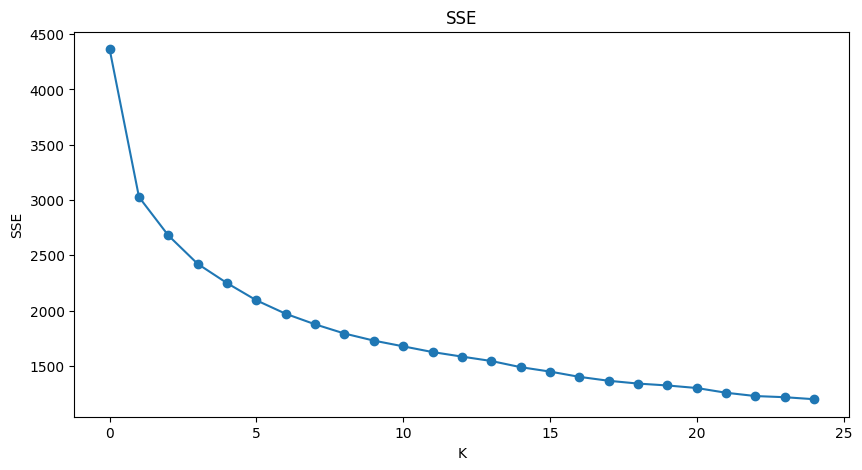

In [24]:
## Plot SSEs
values = sse.values()

# Your code here
plt.figure(figsize=(10,5))
plt.plot(values,marker = 'o')
plt.xlabel("K")
plt.ylabel("SSE")
# plt.ylim(0,1)
# plt.xticks(range(1,16))
plt.title("SSE")
plt.show()

In [25]:
## perform kmeans and add labels to data
km = kmeans_missing(dc2, n_clusters=2)
dc['cluster2'] = km[0]

km = kmeans_missing(dc2, n_clusters=4)
dc['cluster4'] = km[0]

km = kmeans_missing(dc2, n_clusters=14)
dc['cluster14'] = km[0]

## show
dc.head()

,GEOID,NAME,median_income,pct_service,pct_unemp,pct_not_labor,pct_black,pct_public_transit,pct_commute30,pct_poverty,long_centroid,lat_centroid,has_missing,cluster2,cluster4,cluster14
0,110010001011,"Block Group 1, Census Tract 1.01, District of ...",0.731603,-0.514239,-0.589524,0.112327,-1.279042,-1.128366,-1.975999,-0.719556,-77.054725,38.908588,False,0,2,13
1,110010001021,"Block Group 1, Census Tract 1.02, District of ...",0.958231,-0.603732,-0.835314,-1.072545,-1.245247,-1.072531,-1.033557,-0.737394,-77.061333,38.914168,False,0,2,8
2,110010001022,"Block Group 2, Census Tract 1.02, District of ...",1.222093,-0.682336,-0.546640,0.443394,-1.234934,-1.308904,-0.118535,-0.886528,-77.060651,38.909108,False,0,2,12
3,110010001023,"Block Group 3, Census Tract 1.02, District of ...",0.355750,-0.591926,-0.508618,0.405215,-1.279042,-1.404548,-0.507124,-0.604184,-77.061240,38.899200,False,0,2,13
4,110010002012,"Block Group 2, Census Tract 2.01, District of ...",NaN,0.719690,-0.091418,2.277609,-1.015410,-1.640793,-1.985315,NaN,-77.072854,38.908728,True,0,0,2


#### b. K-means + PCA

### 3. Save results

In [28]:
## save results
td = date.today().strftime("%Y%m%d")

# PCA
path = '../data/dc_pca_loadings_' + td + '.csv'
loadings.to_csv(path)

# clustering
path = '../data/dc_bg_clusters_' + td + '.csv'
dc.to_csv(path)